In [48]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
%matplotlib inline

In [50]:
from __future__ import unicode_literals

In [51]:
import sys
import os

In [52]:
sys.path.append('..')

In [53]:
import networkx as nx
import numpy as np
import pandas as pd
from toolz import pipe, map, curry, unique

In [54]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib

In [55]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('font', family='Arial')
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [56]:
%aimport classifier

In [57]:
from toolz.curried import map
from toolz.functoolz import pipe
from toolz.itertoolz import unique

In [58]:
trace_recast = 'wdm'
trace_recastd = 'wdm_graph'

In [59]:
recast_path = '../recast_class/' + trace_recast
recastd_path = '../recastd_class/' + trace_recastd

In [60]:
p_rnd = [1e-6, 1e-5, 1e-4, 1e-3,]

In [61]:
f = open(recast_path + '/' + '0.001.txt')

In [62]:
def read_file(fname, d=None, node=None):
    with open(fname, 'r') as f:
        if d == None:
            d = dict()
        for line in f:
            i, j, k = map(int, line.strip().split(' '))
            if node == None:
                d[(i, j)] = k
                d[(j, i)] = k
            elif i == node:
                d[(i, j)] = k
            elif j == node:
                d[(j, i)] = k
        return d

In [63]:
def build_graph(fname):  
    return nx.parse_edgelist (
        open(fname, 'r'),
        nodetype=int, 
        data=(('class', int),),
        create_using=nx.Graph()
    )

This reads the files generated by *offline* recast 

base3 is the graph with the class assigned by recast when using $p_{rnd} = 10^{-3}$

In [64]:
base3 = read_file(recast_path + os.sep + '0.001.txt')   # 10^-3
base4 = read_file(recast_path + os.sep + '0.0001.txt')  # 10^-4
base5 = read_file(recast_path + os.sep + '1e-05.txt')   # ...
base6 = read_file(recast_path + os.sep + '1e-06.txt')

See **gen_edgelist** to see how I generate these files

In [65]:
map = curry(map)

In [66]:
recastd_files = pipe(
    os.listdir(recastd_path),
    map(lambda x: x.strip('.txt').split('_')[0]),
    unique,
    list
)

classifier*x* is a dict (edge -> class) that stores the class given by recastd for an edge

For instance, $classifier3[(1, 2)]$ = $\textbf{friends}$ means that recast**d** assigned the class **friends** for the pair $(1, 2)$ in the ego graph induced by $1$ when using $p_{rnd} = 10^{-3}$

It's valid to say that the classification is not symmetric. The class of $(x, y)$ is not always the same as $(y, x)$. This is because every node creates it's own ego graph. 

In [67]:
classifier3 = dict()
classifier4 = dict()
classifier5 = dict()
classifier6 = dict()

For every edge in each graph, store the class for that edge according to the $p_{rnd}$ value used.

In [68]:
for i, r, in enumerate(recastd_files):
#     print ('len: {}/{}'.format(i, len(recastd_files)))
    
    read_file(recastd_path + os.sep + r + '_0.001.txt', classifier3, int(r))
    read_file(recastd_path + os.sep + r + '_0.0001.txt', classifier4, int(r))
    read_file(recastd_path + os.sep + r + '_1e-05.txt', classifier5, int(r))
    read_file(recastd_path + os.sep + r + '_1e-06.txt', classifier6, int(r))

In [69]:
# def map_values(node, cls, graph):
#     for j in graph.neighbors_iter(node):
#         cls[(node, j)] = graph.get_edge_data(node, j)['class']

In [70]:
# for i, r in enumerate(recastd_files):
#     print ('len: {}/{}'.format(i, len(recastd_files)))
#     graph3 = read_file(recastd_path + os.sep + r + '_0.001.txt')
#     graph4 = read_file(recastd_path + os.sep + r + '_0.0001.txt')
#     graph5 = read_file(recastd_path + os.sep + r + '_1e-05.txt')
#     graph6 = read_file(recastd_path + os.sep + r + '_1e-06.txt')

#     map_values (int(r), classifier3, graph3)
#     map_values (int(r), classifier4, graph4)
#     map_values (int(r), classifier5, graph5)
#     map_values (int(r), classifier6, graph6)

# Optimal Classification

For every class (friends, bridges, ...) and for every $p_{rnd}$, I compute the number of optimal classifications. 

A classification is said to be optimal if for a pair of nodes $(x, y)$ the class assigned by *recast* is the same assigned by *recastd* on ego_graph$(x)$ and on ego_graph$(y)$

I only check the edges connected to the main node in the ego_graph. For instance, the main node in ego_graph(3) is (obiviously) 3. So, I will only check edges from 3 to any other node.

In [71]:
def classificacao_otima (cls, base):
    opt = dict()
    opt[classifier.friends] = 0
    opt[classifier.bridges] = 0
    opt[classifier.acquaintance] = 0
    opt[classifier.random] = 0
    
    for (x, y) in cls.iterkeys():
#         assert (base.has_edge(x, y))
        c1 = cls[(x, y)]
        c2 = cls[(y, x)]
#         if base.get_edge_data(x, y)['class'] == c1 == c2:
        if base[(x, y)] == c1 == c2:
            opt[c1] += 1
    return opt

In [72]:
otimo3 = classificacao_otima (classifier3, base3)
otimo3

{0: 27868, 2: 5918, 3: 9172, 4: 1178}

In [73]:
otimo4 = classificacao_otima (classifier4, base4)
otimo4

{0: 29438, 2: 4430, 3: 7652, 4: 948}

In [74]:
otimo5 = classificacao_otima (classifier5, base5)
otimo5

{0: 31110, 2: 2948, 3: 4226, 4: 1008}

In [75]:
otimo6 = classificacao_otima (classifier6, base6)
otimo6

{0: 31110, 2: 2948, 3: 4226, 4: 1008}

### pandas analysis

In [76]:
df = pd.DataFrame.from_dict ({
    '$10^{-3}$': otimo3,
    '$10^{-4}$': otimo4,
    '$10^{-5}$': otimo5,
    '$10^{-6}$': otimo6,
})

df = df.transpose()
df.columns = ['Random', 'Friends', 'Acquaintance', 'Bridges']

In [77]:
df['sum'] = df.sum(axis=1)
df = df.loc[:, 'Random':'Bridges'].div(df['sum'], axis=0)
df

,Random,Friends,Acquaintance,Bridges
$10^{-3}$,0.631412,0.134086,0.207812,0.026690
$10^{-4}$,0.693181,0.104314,0.180183,0.022323
$10^{-5}$,0.791764,0.075028,0.107554,0.025654
$10^{-6}$,0.791764,0.075028,0.107554,0.025654


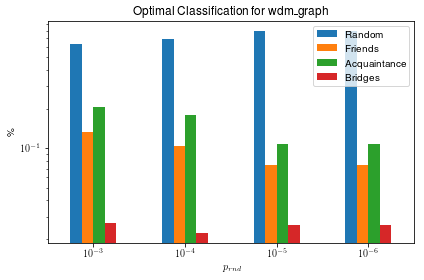

In [78]:
ax = df.plot(kind='bar', 
        logy=True, 
        title='Optimal Classification for {}'.format(trace_recastd.replace('_', '\_')),
        rot=0)

ax.set_ylabel('\%')
ax.set_xlabel('$p_{rnd}$')

fig = ax.get_figure();
# fig.savefig('images/' + trace_recastd + '/classes/optimal.png')

### To where the classes are going?

In [79]:
classes = {
    'friends': classifier.friends,
    'bridges': classifier.bridges,
    'acquaintance': classifier.acquaintance,
    'random': classifier.random,
}

In [80]:
def count_classification (cls, base):
    
    def map_classes (c):
        return {
            0: 'random',
            2: 'friends',
            3: 'acquaintance',
            4: 'bridges',
        }[c]
    
    opt = {
        'friends': {k: 0 for k in classes.keys()},
        'bridges': {k: 0 for k in classes.keys()},
        'acquaintance': {k: 0 for k in classes.keys()},
        'random': {k: 0 for k in classes.keys()},
    }
    for (x, y) in cls.iterkeys():
#         assert (base.has_edge(x, y))
        c0 = map_classes(base[(x, y)])
        c1 = map_classes(cls[(x, y)])
        c2 = map_classes(cls[(y, x)])
        opt[c0][c1] += 1
        opt[c0][c2] += 1
    return opt

In [81]:
count_classification(classifier3, base3)

{u'acquaintance': {u'acquaintance': 18394,
  u'bridges': 0,
  u'friends': 0,
  u'random': 50},
 u'bridges': {u'acquaintance': 0,
  u'bridges': 2452,
  u'friends': 380,
  u'random': 0},
 u'friends': {u'acquaintance': 0,
  u'bridges': 10,
  u'friends': 11846,
  u'random': 0},
 u'random': {u'acquaintance': 1354,
  u'bridges': 0,
  u'friends': 0,
  u'random': 56094}}

##### For each $p_{rnd}$...

In [82]:
def build_table(classifier, base):
    w = count_classification(classifier, base)
    df = pd.DataFrame.from_dict(w)
    df.columns = ['Recast Acquaintance', 'Recast Bridges', 'Recast Friends', 'Recast Random']
    df = df.transpose()
    df.columns = ['RD Acquaintance', 'RD Bridges', 'RD Friends', 'RD Random']
    
    # taking percentage
#     df['sum'] = df.sum(axis=1)
#     df = df.loc[:, 'RD Acquaintance':'RD Random'].div(df['sum'], axis=0)
    return df

##### for base3

In [83]:
df3 = build_table(classifier3, base3)

In [84]:
df3

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,18394,0,0,50
Recast Bridges,0,2452,380,0
Recast Friends,0,10,11846,0
Recast Random,1354,0,0,56094


In the table above, The first column of each row represents the class assigned by Recast and the header (first row) is the class assigned by **Distributed Recast**. For instance, if an edge $(x, y)$ is marked as *friends* by Recast and *Acquaintance* by Distributed Recast, then we count $+1$ in the table[Recast friends][RD Acquaintance]

Note that we're are counting the same edge twice $(x, y)$ and $(y, x)$

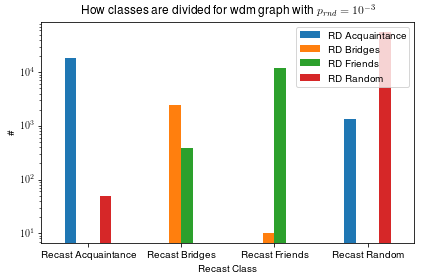

In [85]:
ax = df3.plot(kind='bar', 
              title='How classes are divided for ' + trace_recastd.replace('_', ' ') + ' with $p_{rnd} = 10^{-3}$',
              logy=True, 
              rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\#')

fig = ax.get_figure();
# fig.savefig('images/' + trace_recastd + '/classes/classes3.png')

##### for base4

In [86]:
df4 = build_table(classifier4, base4)

In [87]:
df4

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,15784,0,888,16
Recast Bridges,0,2002,446,0
Recast Friends,0,4,8864,0
Recast Random,1966,734,98,59778


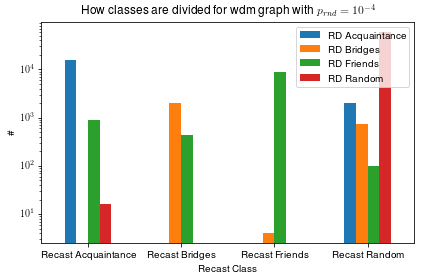

In [88]:
ax = df4.plot(kind='bar', 
         title='How classes are divided for ' + trace_recastd.replace('_', ' ') + ' with $p_{rnd} = 10^{-4}$',
         logy=True,
         rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\#')

fig = ax.get_figure();
# fig.savefig('images/' + trace_recastd + '/classes/classes4.png')

##### for base5

In [89]:
df5 = build_table(classifier5, base5)

In [90]:
df5

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,8454,0,2,0
Recast Bridges,192,2364,2152,232
Recast Friends,286,0,6090,0
Recast Random,7630,16,0,63162


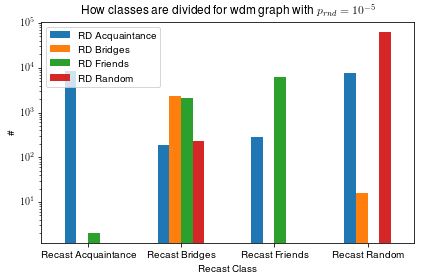

In [91]:
ax = df5.plot(kind='bar', 
         title='How classes are divided for ' + trace_recastd.replace('_', ' ') + ' with $p_{rnd} = 10^{-5}$',
         logy=True,
         rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\#')

fig = ax.get_figure();
# fig.savefig('images/' + trace + '/classes/classes5.png')

##### for base6

In [92]:
df6 = build_table(classifier6, base6)

In [93]:
df6

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,8454,0,2,0
Recast Bridges,192,2364,2152,232
Recast Friends,286,0,6090,0
Recast Random,7630,16,0,63162


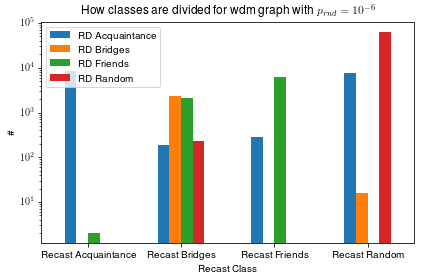

In [94]:
ax = df6.plot(kind='bar', 
         title='How classes are divided for ' + trace_recastd.replace('_', ' ') + ' with $p_{rnd} = 10^{-6}$',
         logy=True,
         rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\#')

fig = ax.get_figure();
# fig.savefig('images/' + trace + '/classes/classes6.png')